In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import inspect
from datetime import datetime, timedelta, date
from adjustText import adjust_text
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import add_preds
from functions import merge_data
import matplotlib.pyplot as plt
cb = '#66ccff'

print('loading data...')
NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7, 8]
df = load_data.load_county_level(data_dir=oj(parentdir, 'data')).fillna(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading data...
loaded and merged COVID-19 cases/deaths data successfully


# add preds for specific date

In [ ]:
import datetime
from datetime import date

d0 = date(2020, 1, 22)
d1 = date(2020, 4, 2)
delta = d1 - d0
delta = delta.days # number of days until 04/02 (starting from jan 22)

# check that it worked
row = df[df['CountyName'] == 'New York'].iloc[0]
print('deaths as of 04-02', row['#Deaths_04-02-2020'])
print('deaths curve last value', row['deaths'][delta])

deaths as of 04-02 165
deaths curve last value 165


In [ ]:
df_past = df.copy()
df_past['deaths'] = df['deaths'].map(lambda x: x[:delta + 1])
df_past['neighbor_deaths'] = df_past['neighbor_deaths'].map(lambda x: x[:delta + 1])
df_past['deaths_continued'] = df['deaths'].map(lambda x: x[delta + 1:])
df_past['tot_deaths'] = df_past['deaths'].map(lambda x: x[-1])
df_past = df_past.sort_values(by='tot_deaths', ascending=False)

In [ ]:
df_past = add_preds(df_past, NUM_DAYS_LIST=NUM_DAYS_LIST,
                    outcomes=['Deaths'], cached_dir='intermediate')

In [ ]:
d.keys()

preds [385, 440.26861810555806, 504.69461184812997, 567.4781950131954, 623.0510409497244, 680.9187827647918, 722.961665296912, 788.7972110467301]
Kings 722.961665296912
preds [499, 565.3101614375139, 637.3489257259456, 703.0535750373865, 757.3241020939156, 814.1466096448577, 863.2956342666116, 934.8684648072009]
Queens 863.2956342666116
preds [421, 483.1659201811784, 543.6832538721552, 606.6806515966441, 673.267497289529, 746.7331598376736, 816.1682331623737, 907.5221770102512]
Bronx 816.1682331623737
preds [95, 111.71409932985621, 134.63995258180654, 159.31006470284387, 187.0956107954062, 218.3510517146904, 236.65255274962146, 278.3844159796801]
Nassau 236.65255274962146
preds [194, 224.15643078723514, 263.1625101642339, 316.0876040495542, 375.7953376797492, 442.8247261487877, 471.3715648539574, 527.7189866727193]
Wayne 471.3715648539574
preds [178, 198.03971093699033, 223.87601501493418, 256.96611476854474, 298.72628238135405, 348.6845127323569, 372.3674447146734, 434.3924985457477]


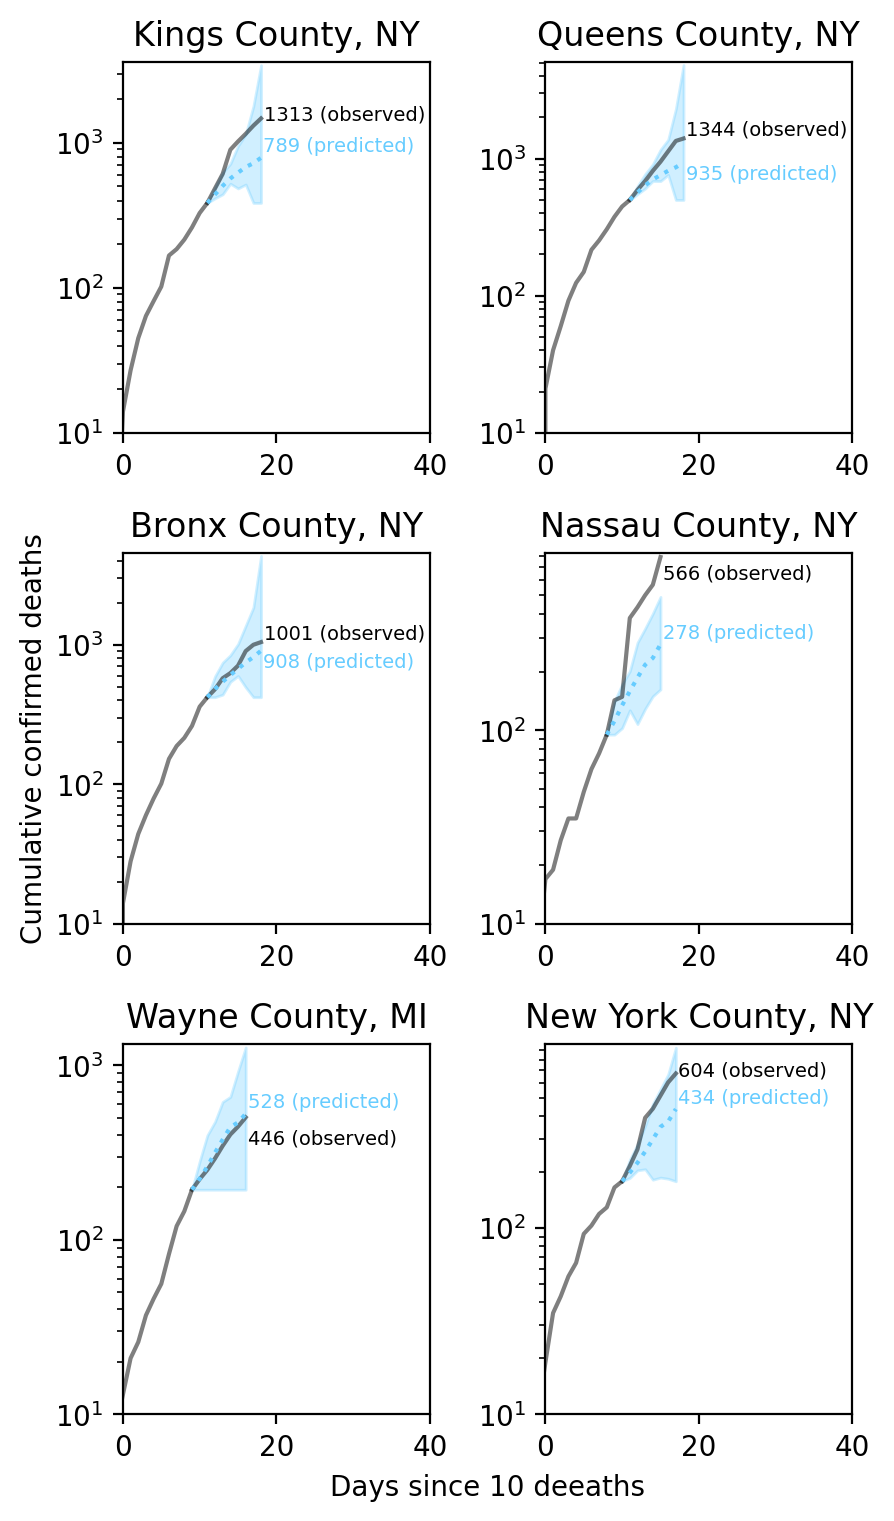

In [ ]:
target = 'deaths'
R, C = 3, 2
NUM_DAYS = 20
NUM_FUTURE = 7
fig = plt.figure(figsize=(5, 8), dpi=200)

for i in range(R * C):
    plt.subplot(R, C, i + 1)
    r = d.iloc[i]
    num = r['deaths']
    plt.title(r['CountyName'] + ' County, ' + r['StateName'])
#     print(r['deaths'][-1])
    deaths = r.deaths #[-num:]
    
    DEATHS_ALIGNMENT = 10
    idx_align_deaths = np.where(deaths > DEATHS_ALIGNMENT)[0][0]
    n2 = deaths.size
    end = NUM_FUTURE - idx_align_deaths + n2 - 1

    # curve
    plt.plot(np.arange(n2) - idx_align_deaths, deaths, alpha=0.5, color='black')
    plt.plot(np.arange(NUM_FUTURE + 1) - idx_align_deaths + n2 - 1,
             [deaths[-1]] + r['deaths_continued'][:NUM_FUTURE].tolist(), color='black',
            alpha=0.5)
    val_final = r['deaths_continued'][NUM_FUTURE - 2]
    texts = []
    texts.append(plt.text(end, val_final,
                          f'{val_final} (observed)', fontsize=7))
    
    intervals = r[f'Predicted {target.capitalize()} Intervals']
    lower = [deaths[-1]] + [x[0] for x in intervals][:NUM_FUTURE]
    upper = [deaths[-1]] + [x[1] for x in intervals][:NUM_FUTURE]
    plt.fill_between(np.arange(end - NUM_FUTURE, end + 1), lower, upper, color=cb, alpha=0.3)

    # predictions
    preds = [deaths[-1]] + [r[f'Predicted Deaths {i}-day'] for i in range(1, NUM_FUTURE + 1)]
    print('preds', preds)
    print(r['CountyName'], preds[-2])
    plt.plot(np.arange(NUM_FUTURE + 1) - idx_align_deaths + n2 - 1, preds, linestyle='dotted', color=cb)
    plt.xlim(left=0, right=40) # extend lim to make space for labels
    plt.ylim(bottom=10)
    val_pred = preds[-1]
    
    texts.append(plt.text(end, val_pred,
                          f'{val_pred:.0f} (predicted)', fontsize=7,
                          color=cb)
                )
    
    plt.yscale('log')
    adjust_text(texts) #, only_move={'points': 'y',
#                               'text': 'y',
#                               'objects': 'y'}) #, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Days since 10 deeaths")
plt.ylabel("Cumulative confirmed deaths")    
    
plt.tight_layout()
plt.show()